# Phiên bản song song đầu tiên

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

path_final = "/content/drive/MyDrive/LTSSUD"
import os

if (os.path.isdir(path_final) == True):
  %cd "/content/drive/MyDrive/LTSSUD"

!ls

Mounted at /content/drive
/content/drive/MyDrive/LTSSUD
Data_Preparation___Image_processing.ipynb  Proposal.gdoc
dataset					   results_base.pkl
Final_report.ipynb			   results_img_acc.pkl
handle_imb.ipynb			   results.pkl
lib_results.pkl				   sequence.ipynb
models					   train_data_128_full.npz
parallel.ipynb				   winequality-red.csv
parallel_v1.ipynb			   XGB_regression.ipynb


In [ ]:
import numpy as np
import pandas as pd
import sys
import math
import time
import matplotlib.pyplot as plt
from numba import cuda
import cProfile
#from numba import jit

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute  import SimpleImputer
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
#np.set_printoptions(threshold=sys.maxsize)

**Những phần có khả năng song song hóa:**
- XGB tree
  - `find_best_split`: Tìm ra điểm dữ liệu tốt nhất để chia dữ liệu
  - `similarity`: Hàm tính giá trị similarity cho output và gain
- XGB Classifier
  - `residuals`: Tính giá trị sai lệch
  - `converter`: Chuyển probability sang dạng log(odds)

Ở phần trước khi chạy mô hình XGB tuần tự thì hàm `find_best_split` chiếm nhiều thời gian và số lần để chạy nhất. Nên nhóm sẽ tập trung song song hóa hàm này ở phiên bản song song này. Hàm này được chia ra làm 3 phần nhỏ và tất cả các phần đều song song được

## Các hàm được song song hóa:

### 3 hàm nhỏ trong find_best_split

In [ ]:
@cuda.jit
def mean_array(a, res): #Hàm tạo mảng tất cả các giá trị split_value của từng feature để tiến hành song song hóa
  r = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
  c = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
  if(r < res.shape[0] and c < res.shape[1]):
    if(a[r, c] != a[r + 1, c]): #Chỉ lấy các giá trị khác nhau để tính mean còn lại sẽ trả về giá trị nan
      tmp = 0
      tmp = (a[r,c] + a[r+1,c])/2
      res[r,c] = tmp
    else:
      res[r,c] = np.nan

In [ ]:
a = np.array([[1,3,2,2],[1,3,4,4],[1,34,45,56],[1,37,50,60],[2,39,61,61]])#Mảng giả lập được sort sẵn
a = np.sort(a, axis=0)
res = np.empty((4,4))
mean_array[(1,1),(4,4)](a, res)
print(a)#Mảng ban đầu
print(res)#Mảng trả về

[[ 1  3  2  2]
 [ 1  3  4  4]
 [ 1 34 45 56]
 [ 1 37 50 60]
 [ 2 39 61 61]]
[[ nan  nan  3.   3. ]
 [ nan 18.5 24.5 30. ]
 [ nan 35.5 47.5 58. ]
 [ 1.5 38.  55.5 60.5]]


Lấy output của hàm trên làm input của hàm dưới đây:

In [ ]:
#Hàm này tính gain từ mảng split_values. Mỗi giá trị trong mảng split được 1 thread đảm nhiệm.
@cuda.jit
def cal_gain(split_val, X, y, p, min_impurity, res): #Hàm này trả về một mảng có kích thước bằng với mảng split_val nhưng mỗi giá trị split trong nó sẽ là giá trị gain tương ứng.
  r = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
  c = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
  if(r < split_val.shape[0] and c < split_val.shape[1]):
    if(split_val[r, c] != np.nan): #skip các giá trị nan
      l_numerator = 0 #Phần tử số là gradient (tổng các residuals ở đây là y) 'l' là bên trái còn 'r' là bên phải giá trị split
      r_numerator = 0
      l_denominator = 0 #Phần tử số là hessian (tổng p*(1-p), với p là probability) 'l' là bên trái còn 'r' là bên phải giá trị split
      r_denominator = 0
      for i in range(X.shape[0]):
        if(X[i,c] <= split_val[r,c]):
          l_numerator = l_numerator + y[i]
          l_denominator = l_denominator + p[i]*(1 - p[i])
        else:
          r_numerator = r_numerator + y[i]
          r_denominator = r_denominator + p[i]*(1 - p[i])
      l_sim = (l_numerator**2)/(l_denominator + min_impurity)
      r_sim = (r_numerator**2)/(r_denominator + min_impurity)
      gain = l_sim + r_sim #giá trị gain được tính bằng công thức [gain = left_similarity + right_similarity - root_similarity]. root_similarity được cộng bên ngoài
      res[r,c] = gain
    else:
      res[r,c] = np.nan

### Các hàm song song hóa còn lại

In [ ]:
#Hàm này tính giá trị sai lệch giữa 2 mảng chức năng giống với a - b trong đó a,b là hai mảng np.array
@cuda.jit
def residuals_kernel(y_true, y_pred, result):
    i = cuda.grid(1)
    if i < y_true.shape[0]:
        result[i] = y_true[i] - y_pred[i]

In [ ]:
#Hàm này chuyển tỉ lệ từ đoạn [0,1] sang dạng log(odds)
@cuda.jit
def converter_kernel(p, result):
    i = cuda.grid(1)
    if i < len(p):
      result[i] = math.log(p[i]/(1-p[i]))

## Thuật toán XGBoost

In [ ]:
class XGBoostTree:
    def __init__(self, max_depth=3, min_samples_split=1, min_impurity=1e-7, gamma = 0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.gamma = gamma
        self.tree = {}
        self.fbs_t = [0,0]

    #split_data chia dữ liệu ra làm đôi
    def split_data(self, X, feature_index, split_value):
        left_indices = X[:, feature_index] <= split_value
        right_indices = X[:, feature_index] > split_value
        return left_indices, right_indices

    #Tính tất cả giá trị similarity của mảng input
    def similarity(self, y_true, p, i = 2):
        numerator = np.sum(y_true)**i
        denominator = np.sum(p * (1 - p)) + self.min_impurity
        return numerator / denominator

    #Tìm giá trị split có gain cao nhất trong mảng input
    #Đây là hàm được nhóm tiến hành cài đặt song song chính vì nó tốn nhiều thời gian để chạy nhất
    #Bên phiên bản tuần tự thì hàm này xử dụng 2 vòng lặp để tìm ra gain cũng như là gian lớn nhất
    #Tại phiên bản này nhóm em sẽ biến nó thành mảng 2 chiều và tiến hành song song hóa nó.
    #Các giá trị split được tạo ra nhờ việc tính trung bình giữa 2 điểm dữ liệu kế nhau trên cùng 1 feature sau khi mảng feature này đã được sort
    #Sau đó từ các giá trị split này được tính thành gain
    #Phiên bản tuần tự khác ở chỗ các kích thước mảng feature qua n vòng lặp (n là số feature) không bằng nhau. Bởi vì nó lấy np.unique() của mảng này
    def find_best_split(self, X, y, probs):
        best_gain = -np.inf
        best_split_feature = None
        best_split_value = None

        num_samples, num_features = X.shape
        split_values = np.empty((X.shape[0]-1, X.shape[1])) #khởi tạo
        block_size = (32,32)
        grid1 = (math.ceil(split_values.shape[1]/block_size[0]),math.ceil(split_values.shape[0]/block_size[1]))
        mean_array[grid1, block_size](np.sort(X, axis=0).astype(np.float64), split_values)


        gains = np.empty((split_values.shape[0], split_values.shape[1])) #khởi tạo
        grid2 = (math.ceil(split_values.shape[1]/block_size[0]),math.ceil(split_values.shape[0]/block_size[1]))
        cal_gain[grid2, block_size](split_values, X, y, probs, self.min_impurity, gains)

        gains = gains - self.similarity(y, probs) #Trừ đi root similarity
        gains[np.isnan(gains)] = -np.inf #Gán nan bằng trừ vô cực để loại

        if(np.sum(gains == -np.inf) != gains.shape[0]*gains.shape[1]): #vì bên phần tuần tự giá trị lớn nhất sẽ ưu tiên từ bên trái trên cùng khác với hàm np.argmax()
          tmp = np.rot90(gains, axes = (1,0)) #rotate và flip để giá trị tìm đươc đúng thứ tự ưu tiên
          tmp = np.flip(tmp,1)
          midx = np.unravel_index(np.argmax(tmp, axis=None), tmp.shape)
          midx = (midx[1], midx[0])
          best_split_feature = midx[1]
          best_gain = gains[midx]
          best_split_value = split_values[midx]

        if(best_gain - self.gamma < 0):
            best_split_feature = None
            best_split_value = None

        return best_split_feature, best_split_value

    #Tạo node lá
    def create_leaf_node(self, y, probs):
        return self.similarity(y, probs, 1)

    #Dựng cây
    def build_tree(self, X, y, probs, depth=0):
        if depth >= self.max_depth or len(X) <= self.min_samples_split:#đụng max depth thì tạo node lá
            return self.create_leaf_node(y, probs)

        start = time.time()
        split_feature, split_value = self.find_best_split(X, y, probs)
        end = time.time()
        self.fbs_t[0] += 1
        self.fbs_t[1] += (end - start)

        if split_feature is None:#Nếu không tìm được điểm split hợp lý cũng dừng và tạo lá
            return self.create_leaf_node(y, probs)

        left_indices, right_indices = self.split_data(X, split_feature, split_value)
        left_child = self.build_tree(X[left_indices], y[left_indices], probs[left_indices], depth + 1)#Dựng độ sâu tiếp theo
        right_child = self.build_tree(X[right_indices], y[right_indices], probs[right_indices], depth + 1)#Dựng độ sâu tiếp theo

        self.tree = {
            'split_feature': split_feature,
            'split_value': split_value,
            'left_child': left_child,
            'right_child': right_child
        }

        return self.tree

    def fit(self, X, y, probs):
        self.tree = self.build_tree(X, y, probs)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    #Truy suất cây được tạo để dự đoán giá trị
    def _traverse_tree(self, x, node):
        if isinstance(node, dict):
            split_feature = node['split_feature']
            split_value = node['split_value']
            if x[split_feature] <= split_value:
                return self._traverse_tree(x, node['left_child'])
            else:
                return self._traverse_tree(x, node['right_child'])
        else:
            return node

In [ ]:
#Loss function
def n_log_likelihood(y_true, y_pred):
    return -np.sum(y_true*np.log(y_pred)+ (1 - y_true)*np.log(1 - y_pred))

#Chuyển sang log(odds). Hàm này được nhóm tiến hành song song hóa ở trên
def converter(p):
        return np.log(p/(1-p)).astype(np.float64)

#Tính giá trị sai lệch. Hàm này được nhóm tiến hành song song hóa ở trên
def residuals(y_true, y_pred):
    return (y_true - y_pred).astype(np.float64)

#Trả về đoạn [0,1] giống sigmoid (chỉ để thử nghiệm)
def softmax(z):
    return np.exp(z)/(np.sum(np.exp(z), axis = 0))

def probability(y):
    p = np.sum(y == 1)/np.sum(y != 1)
    p = p/(1+p)
    ans = np.copy(y).astype(np.float64)
    ans[y == 1] = p
    ans[y != 1] = 1-p
    return ans

#Tạo cây dự đoán từ các sai lệch
def build_weak_learner(X, y, probs, min_impurity, gamma):
    model = XGBoostTree(min_impurity = min_impurity, gamma = gamma)  # Chỉnh siêu tham số
    model.fit(X, y, probs)
    return model #Trả về tree model

# Tạo XGBoost model
class XGBoostModel:
    def __init__(self, n_estimators, learning_rate, min_impurity = 1e-7, gamma = 0, debug = 0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.initial_prediction = 0
        self.min_impurity = min_impurity
        self.gamma = gamma
        self.debug = debug
        self.models = []
        self.fbs_t = [0,0] #các giá trị _t để đo thời gian
        self.con_t = [0,0]
        self.res_t = [0,0]

    def fit(self, X, y):
        data = X
        classes, counts = np.unique(y, return_counts=True)
        self.initial_prediction = 0.5 #Giá trị dự đoán ban đầu có nghĩa là nếu n_estimators = 0 tất cả tỉ lệ dự đoán sẽ là 50%
        predictions = np.full(len(y), self.initial_prediction, dtype =np.float64)
        # Vòng lặp build tree model nơi mà model sau xử dụng kết quả dự đoán được của model trước đó
        for _ in range(self.n_estimators):
            probs = np.copy(predictions)
            residual = np.empty(len(y))
            block_size = 32
            grid = math.ceil(len(residual)/block_size)
            start = time.time()
            residuals_kernel[grid, block_size](y, predictions, residual)#Tính residual
            end = time.time()
            self.res_t[0] += 1
            self.res_t[1] += (end - start)

            # Fit hàm weak learner
            model = build_weak_learner(data, residual, probs, self.min_impurity, self.gamma)
            self.fbs_t[0] += model.fbs_t[0]
            self.fbs_t[1] += model.fbs_t[1]

            #Cập nhật dự đoán
            log_odds = np.empty(len(y))
            block_size = 32
            grid = math.ceil(len(residual)/block_size)
            start = time.time()
            converter_kernel[grid, block_size](predictions, log_odds)#Tính log(odds)
            end = time.time()
            self.con_t[0] += 1
            self.con_t[1] += (end - start)
            t = log_odds + self.learning_rate * model.predict(data)
            predictions = np.around(np.exp(t) / (1 + np.exp(t)), decimals = 14)#Làm tròn đến số thập phân thứ 14 để tránh tràn float64
            if(self.debug == 1):
              print("n_log_likelihood: " + str(n_log_likelihood(y, predictions)))

            # thêm model này vào chuỗi model từ đó hàm loss sẽ dân được cải thiên qua từng lần lặp
            self.models.append(model)

    def predict_proba(self, X):

        predictions = np.full(len(X),self.initial_prediction)
        for model in self.models:
            t = np.log(predictions/(1-predictions)) + self.learning_rate * model.predict(X)
            predictions = np.around(np.exp(t) / (1 + np.exp(t)), decimals = 14)

        return predictions

    def predict(self,X):
        return (self.predict_proba(X) > self.initial_prediction).astype(int)

**Dưới đây là 2 ví dụ được chạy với cùng 1 bộ trọng số trên cả 2 file gồm file này và file sequence.ipynb để có được một cái nhìn tổng quát nhất về 2 phiên bản này (ví dụ này không bao gồm phần OVA)**

## 1. Binary Classification

### 1. Wine dataset

Nhóm em sẽ tiến hành so sánh trên tập dữ liệu nhỏ trước vì dữ liệu gốc trên tập loài cây thì quá lớn so với phiên bản tuần tự.

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
dat = pd.read_csv('winequality-red.csv')
dat['quality'] = pd.cut(dat['quality'], bins=[2, 5, 8], right=True, labels=False)+1
y = dat['quality']= le.fit_transform(dat['quality'])
X = dat.drop(['quality'], axis=1).select_dtypes(exclude=['object'])
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state = 0)
train_X.fillna(0, inplace = True)
test_X.fillna(0, inplace = True)
my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

In [ ]:
print(train_X.shape)

(1199, 11)


In [ ]:
np.mean(train_y)

0.5337781484570475

In [ ]:
# Tạo và train XGBoost model
xgb_model = XGBoostModel(n_estimators=100, learning_rate=0.3, min_impurity = 0, gamma = 0)
start = time.time()
xgb_model.fit(train_X, train_y)
end = time.time()

In [ ]:
y_pred = xgb_model.predict(test_X)

In [ ]:
from sklearn.metrics import accuracy_score
print("accuracy_score : " + str(accuracy_score(test_y, y_pred)))

accuracy_score : 0.78


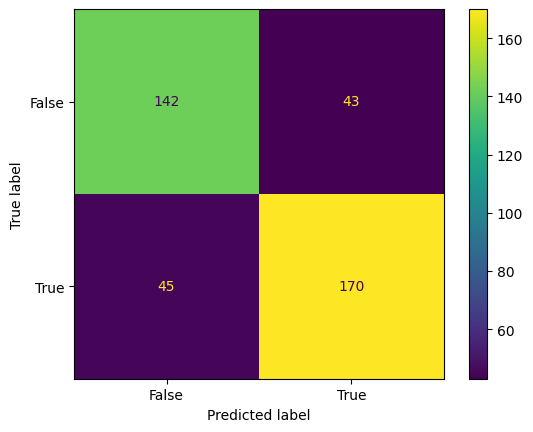

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(test_y, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
print("Total time: " + str(end-start))

Total time: 5.4539361000061035


In [ ]:
print("find_best_split total: " + str(xgb_model.fbs_t[0]) + ' in ' + str(xgb_model.fbs_t[1]) + 's')
print("residuals total: " + str(xgb_model.res_t[0]) + ' in ' + str(xgb_model.res_t[1]) + 's')
print("converter total: " + str(xgb_model.con_t[0]) + ' in ' + str(xgb_model.con_t[1]) + 's')

find_best_split total: 684 in 4.795714855194092s
residuals total: 100 in 0.22132229804992676s
converter total: 100 in 0.19327044486999512s


Ta có thể thấy thời gian được cải thiện đi rất nhiều ở các phần song cụ thể là gần 8 lần. Tuy nhiên sự cải thiên này chắc chắn sẽ lớn hơn nhiều khi ta thử trên tập dữ liệu lớn. Sự cải thiện này chủ yếu là từ hàm `find_best_split`

## 2. Multi-Classification

### 1. OVO

In [ ]:
train = np.load('train_data_128_full.npz',allow_pickle=True)
test = np.load('dataset/test_data_128_full.npz',allow_pickle=True)
train_X = train['data']
train_y = train['label'].astype(int)
train_p = train['plant'].astype(int)
train_X = train_X[train['plant'] == 0]
train_y = train_y[train['plant'] == 0]
test_X = test['data']
test_y = test['label']
test_p = test['plant']
test_X = test_X[test['plant'] == 0]
test_y = test_y[test['plant'] == 0]

In [ ]:
print(train_X.shape)

(4108, 532)


Phương pháp tiếp cận đầu tiên One vs All

In [ ]:
classes, counts = np.unique(train_y, return_counts=True)
models = []
preds = []
total_time = 0
for c in tqdm(classes):
  y_t = (train_y == c)
  t = XGBoostModel(n_estimators=10, learning_rate=0.4, min_impurity = 0, gamma = 0)
  start = time.time()
  t.fit(train_X,y_t)
  end = time.time()
  total_time += (end - start)
  models.append(t)
  preds.append(models[c].predict_proba(test_X))
pred = np.argmax(preds, axis=0)

100%|██████████| 4/4 [00:59<00:00, 14.81s/it]


In [ ]:
print("accuracy_score : " + str(accuracy_score(test_y, pred)))

accuracy_score : 0.8911671924290221


In [ ]:
print("Total time: " + str(total_time))

Total time: 59.147464990615845


In [ ]:
print("find_best_split total: " + str(sum([models[i].fbs_t[0] for i in classes])) + ' in ' + str(sum([models[i].fbs_t[1] for i in classes])) + 's')
print("residuals total: " + str(sum([models[i].res_t[0] for i in classes])) + ' in ' + str(sum([models[i].res_t[1] for i in classes])) + 's')
print("converter total: " + str(sum([models[i].con_t[0] for i in classes])) + ' in ' + str(sum([models[i].con_t[1] for i in classes])) + 's')

find_best_split total: 277 in 58.04816770553589s
residuals total: 40 in 0.06884360313415527s
converter total: 40 in 0.06046104431152344s


Ở tập dữ liệu lớn hơn thì thời gian nhanh hơn đã không còn là 8 lần mà con số này đã tăng lên nhiều hơn cụ thể là gần 68 lần. Và hàm `find_best_split` vẫn là hàm chiếm đa số thời gian chạy.

### 2. OVA

Điều chỉnh tập dữ liệu train của phương pháp `One vs All`. Vì khi huấn luyện thì tập dữ liệu không được cân bằng, giả sử phần lớp 1 so với 37 phần lớp còn lại thì khá lớn.
- Giải pháp tạm thời cân bằng phần lớp 1 và 37 phần lớp còn lại. Lựa chọn phần lớp `One` và phân lớp `All` được chọn ngẫu nhiên sao cho số lượng 2 phần lớp ngang bằng nhau.

In [ ]:
def balance_data_by_random_choice(y_t, number):
  len_num = np.count_nonzero(y_t)
  random_locate = np.random.choice(len(np.where(y_t == 0)[0]), size=len_num)
  final_locate = np.concatenate([np.where(y_t == 1)[0], random_locate])
  # print(len(train_X[final_locate]))
  # print(len(train_y[final_locate]))
  return train_X[final_locate], y_t[final_locate]

In [ ]:
classes, counts = np.unique(train_y, return_counts=True)
models = []
preds = []
total_time = 0
for c in tqdm(classes):
  y_t = (train_y == c).astype(int)
  t = XGBoostModel(n_estimators=300, learning_rate=0.3, min_impurity = 0, gamma = 0)
  start = time.time()
  train_bl_X, y_bl_t = balance_data_by_random_choice(y_t, c)
  t.fit(train_bl_X,y_bl_t)
  end = time.time()
  total_time += (end - start)
  models.append(t)
  preds.append(models[c].predict_proba(test_X))

pred = np.argmax(preds, axis=0)

100%|██████████| 38/38 [5:45:49<00:00, 546.05s/it]


In [ ]:
print("Total time: " + str(total_time))

Total time: 20245.964371442795


In [ ]:
print("find_best_split total: " + str(sum([models[i].fbs_t[0] for i in classes])) + ' in ' + str(sum([models[i].fbs_t[1] for i in classes])) + 's')
print("residuals total: " + str(sum([models[i].res_t[0] for i in classes])) + ' in ' + str(sum([models[i].res_t[1] for i in classes])) + 's')
print("converter total: " + str(sum([models[i].con_t[0] for i in classes])) + ' in ' + str(sum([models[i].con_t[1] for i in classes])) + 's')

find_best_split total: 335456 in 19880.775080680847s
residuals total: 11400 in 16.26919388771057s
converter total: 11400 in 11.690053224563599s


In [ ]:
print("accuracy_score : " + str(np.mean((test_y - pred)==0)))

accuracy_score : 0.8552242203505577


Ta có thể nhận thấy tốc độ thời gian được cải thiện vì khi mô hình huấn luyện với tập dữ liệu ít hơn, điều này giúp tốc độ huấn luyện của mô hình được cải thiện nhiều hơn.

Tương ứng với đó thì độ chính xác cũng được cải thiện tốt hơn, tuy nhiên nếu tăng giá trị n_estimator dần dần độ chính xác sẽ đạt điểm tiệm cận `0.8965399499203278` và càng tăng n_estimator thì có thể điểm sẽ bị giảm. Điều này khá đúng, bởi vì chúng ta lựa chọn các phân lớp khác bằng `random.choice` nên có thể khiến mô hình học không đủ toàn bộ dữ liệu.



### Các hàm xây dựng cho việc training

Các hàm dưới đây được nhóm em xử dụng trên toàn bộ tập dữ liệu để tạo ra các model dự đoán theo phương thức one vs one

In [ ]:
#Hàm này để predict khi model đã được lưu thành file .pkl (chỉ dành cho phương thức ovo)
def predict(model, classes, test):#phần tệp pkl được lưu gồm nhiều phần của model trong đó model chính có tên model và phần khác là class cũng là 2 biến của hàm này.
  preds = []
  pred = []
  for i in range(len(classes)):
    preds.append([])
    for c in range(len(classes)):
      if(c < i):
        preds[i].append(list(1 - np.array(preds[c][i]))) #đây là những model không cần phải build lại nhóm sẽ lấy 1 trừ cho khả năng tương ứng đã dự đoán trước đó.
        continue
      if(c == i):
        preds[i].append(np.full(test.shape[0], 1))#gán bằng 1 vì phân loại nó với chính nó.
        continue
      preds[i].append(model[i][c].predict_proba(test))
    pred.append(np.sum(preds[i], axis = 0))

  pred = np.argmax(pred, axis=0)
  return pred.astype(int)

In [ ]:
#Hàm này sẽ bắt đầu hoặc tiếp tục train model theo phương thức one vs one. Để đề phòng khi colab bị run out gpu
def cont_train_ovo(X, y, f_name):#f_name là tên file file được lưu dưới dạng pickle của list 2 chiều kích thước k x k với k là số phân lớp, X và y lầ tập train x và y để train model
  if(os.path.isfile(f_name)):#kiểm tra model đã tồn tại hay chưa. Nếu chưa thì tạo cái mới
    frag = 1
    models = pd.read_pickle(f_name)['models']
    total_time = pd.read_pickle(f_name)['total_time']
  else:
    frag = 0
    models = []
    total_time = 0

  classes, counts = np.unique(y, return_counts=True)

  l = len(models)
  for i in tqdm(range(l, len(classes))):#OVO sẽ tạo ra (k(k-1))/2 model
    models.append([])
    for c in range(len(classes)):
      y_t = y[(y == i) | (y == c)]#Lọc dữu liệu có phân lớp tương ứng
      X_t = X[(y == i) | (y == c)]
      y_t = (y_t == i)
      start = time.time()
      if(c < i):#Các phân lớp đã đụng nhau rồi thì sẽ không cần phải build lại nữa
        models[i].append(np.nan)
        continue
      if(c == i):#với chính nó thì cũng không cần build
        models[i].append(np.nan)
        continue
      t = XGBoostModel(n_estimators=50, learning_rate=0.3,min_impurity= 0, gamma = 0, max_depth = 5)
      t.fit(X_t,y_t)
      end = time.time()
      total_time += (end - start)
      models[i].append(t)
    s_data = {'total_time': total_time, 'models': models, 'classes': classes}#lưu tiến độ
    with open(f_name, 'wb') as file:
      pickle.dump(s_data, file)
  return models